In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For i/o paths
from pathlib import Path

import m3code
import analysis

# For map visualization
import cartopy.crs as ccrs
import mapviz

# For manipulating colors
import matplotlib.colors as mplcolors

# For calculating correlations
import scipy.stats

In [2]:
# Data paths
import json
data_dir = Path().resolve().parent / 'original' / 'selected_geotagged_tweet_data'
with (data_dir / 'file_names.json').open(mode='r') as f:
    file_names_dict = json.load(f)
all_file = data_dir / file_names_dict['all']['filename']

pop_dir = Path().resolve().parent / 'scratch' / 'population'
res_pop_file = pop_dir / 'census2015mesh3_totalpop_setai_area.csv'
emp_pop_file = pop_dir / 'economiccensus2016mesh3_jigyosyo_jugyosya_area.csv'

figdir = Path().resolve().parent / 'figure'

In [3]:
# Plot settings
plt.rcParams['font.family'] = ['sans-serif', 'serif']
plt.rcParams["font.sans-serif"] = ['Helvetica']
plt.rcParams['font.serif'] = ['Palatino']
SMALL_FONT_SIZE = 9
MEDIUM_FONT_SIZE = 11
LARGE_FONT_SIZE = 12.5
PANEL_LABEL_SIZE = 16
PANEL_LABEL_FONT = 'DejaVu Sans'
plt.rcParams.update({'font.size': MEDIUM_FONT_SIZE})

In [5]:
# Load data
all_df = pd.read_csv(all_file, dtype={'m3code':str})
if not all_df['m3code'].is_unique:
    print('Total data: \"m3code\" is not unique.')
all_df['density'] = all_df['tweetcount'] / all_df['area']
all_df[['latitude', 'longitude']] = m3code.latlon(all_df)

res_df = pd.read_csv(res_pop_file, dtype={'m3code':str, 'KEY_CODE':str})
if not res_df['m3code'].is_unique:
    print('Residential population: \"m3code\" is not unique.')
res_df['density'] = res_df['POPULATION'] / res_df['area']

emp_df = pd.read_csv(emp_pop_file, dtype={'m3code':str, 'KEY_CODE':str})
if not emp_df['m3code'].is_unique:
    print('Employment population: \"m3code\" is not unique.')
emp_df['density'] = emp_df['JUGYOSYA'] / emp_df['area']

In [6]:
all_df

,m3code,tweetcount,area,density,latitude,longitude
0,30275333,1,1.203418,0.830966,20.445833,127.41875
1,30346262,9,1.202588,7.483860,20.554167,134.28125
2,30365005,1,1.203609,0.830835,20.420833,136.06875
3,30365015,81,1.203545,67.301181,20.429167,136.06875
4,30365016,11,1.203545,9.139667,20.429167,136.08125
...,...,...,...,...,...,...
299209,68482711,1,0.904724,1.105309,45.512500,148.89375
299210,68482721,1,0.904591,1.105472,45.520833,148.89375
299211,68496778,2,0.898623,2.225627,45.895833,149.98125
299212,68497717,1,0.898090,1.113474,45.929167,149.96875


In [7]:
def dms2dd(dms):
    '''Convert the degrees, minutes, seconds notation to decimal degrees'''
    return dms[0] + dms[1] / 60 + dms[2] / 3600

# Reachable extreme points of Japan
east_ext = dms2dd((145, 48, 58))
west_ext = dms2dd((122, 56, 1))
south_ext = dms2dd((24, 2, 59))
north_ext = dms2dd((45, 31, 22))

center_lon = dms2dd((139, 44, 28))
center_lat = dms2dd((35, 39, 29))
lon_diff = east_ext - west_ext
lat_diff = north_ext - south_ext
extent = (west_ext-lon_diff*0.05, east_ext+lon_diff*0.05, 
          south_ext-lat_diff*0.05, north_ext+lat_diff*0.05)

lambert_area_proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=center_lon, 
    central_latitude=center_lat)

In [8]:
# Merge dataframes to calculate correlation

# Merge with how='right' to exclude cells outside Japan
all_res_df = pd.merge(all_df, res_df, on='m3code', how='right', suffixes=['_all', '_res'])
for col in ['tweetcount', 'density_all', 'POPULATION', 'density_res']:
    all_res_df[col] = all_res_df[col].fillna(0)
    
all_emp_df = pd.merge(all_df, emp_df, on='m3code', how='right', suffixes=['_all', '_emp'])
for col in ['tweetcount', 'density_all', 'JUGYOSYA', 'density_emp']:
    all_emp_df[col] = all_emp_df[col].fillna(0)
    
# Merge res_df and emp_df with how='outer' to include cells inside Japan
res_emp_df = pd.merge(res_df, emp_df, on='m3code', how='outer', suffixes=['_res', '_emp'])
# Merge res_emp_df and all_df with how='right' to exclude cells outside Japan
all_census_df = pd.merge(all_df, res_emp_df, on='m3code', how='right', suffixes=['_all', '_census'])\
    .rename(columns={'density':'density_all'})
for col in ['tweetcount', 'density_all', 'POPULATION', 'density_res', 'JUGYOSYA', 'density_emp']:
    all_census_df[col] = all_census_df[col].fillna(0)

In [9]:
def power_law_pdf(x, exponent, xmin, discrete=True):
    if discrete:
        import scipy.special
        pdf = x**(- exponent) / scipy.special.zeta(exponent, xmin)
    else:
        pdf = (exponent - 1) * (x / xmin)**(- exponent) / xmin
    return pdf

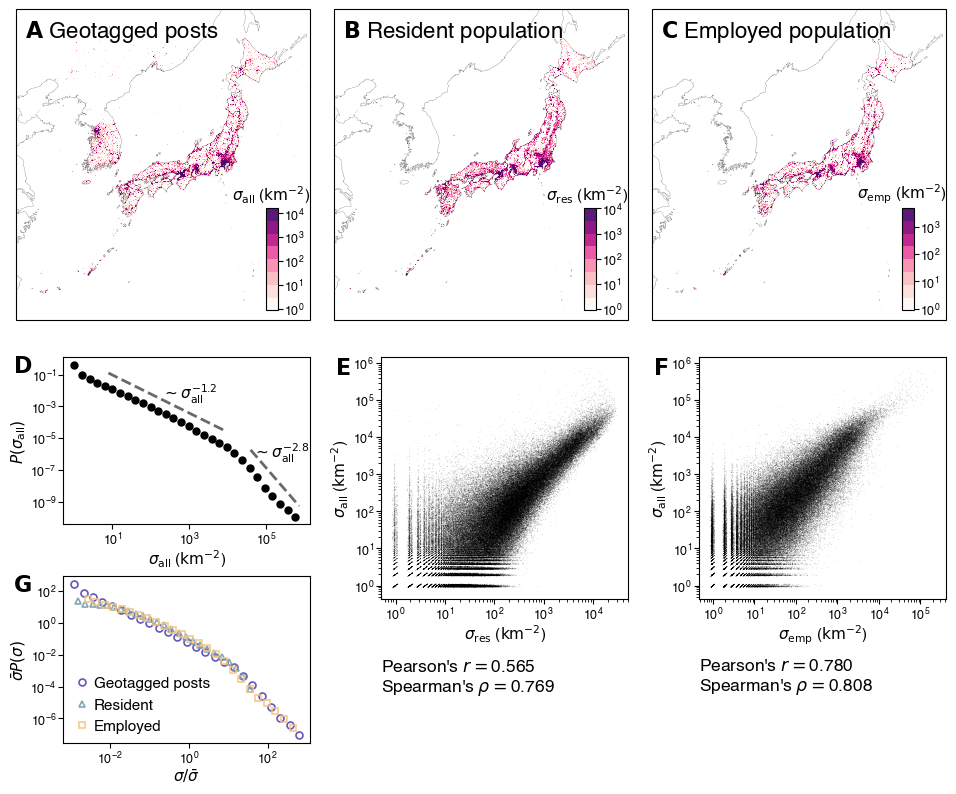

In [10]:
# fig = plt.figure(figsize=(15, 10.5))
fig = plt.figure(figsize=(12, 9))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 0.95], hspace=-0.25)
map_axes = subfigs[0].subplot_mosaic(
    """
    ABC
    """, 
    per_subplot_kw={
        ("A", "B", "C"): {"projection": lambert_area_proj},
    }, 
    gridspec_kw={
        "wspace": 0.08,
    }
)

cmap = plt.get_cmap('RdPu', 8)
panel_title_loc = (0.03, 0.91)
# A, B, C
for df, descr, subscr, panel_label in zip([all_df, res_df, emp_df], 
                                    ['Geotagged posts', 'Resident population', 'Employed population'],
                                    ['all', 'res', 'emp'],
                                    ['A', 'B', 'C']):
    ax = map_axes[panel_label]
    data_lon = df['longitude'].to_numpy()
    data_lat = df['latitude'].to_numpy()
    data_val = df['density'].to_numpy()
    norm = mplcolors.LogNorm(vmax=np.quantile(data_val, 0.99))
    cblabel=r'$\sigma_\mathrm{{{}}}$ ($\mathrm{{km}}^{{-2}}$)'.format(subscr)
    map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj, ax=ax, lw=0.2, color='dimgrey', resolution='10m')
    map_data.visualize(data_lon, data_lat, data_val, cmap=cmap, norm=norm, size=0.03, alpha=0.9)
    cb = map_data.add_colorbar(orientation='vertical')
    cb.ax.tick_params(labelsize=SMALL_FONT_SIZE, pad=1)
    cb.ax.minorticks_off()
    cb.ax.set_yticks(np.power(10, np.arange(np.ceil(np.log10(data_val[data_val > 0].min())), 
                                            np.floor(np.log10(np.quantile(data_val, 0.99))) + 1)))
    cb.set_label(cblabel, rotation=0, va='bottom', y=1.03)
    # mapviz.scale_bar(ax=map_data.ax, length=100, location=(0.5, 0.05), linewidth=2)
    ax.text(*panel_title_loc, rf'$\bf{{{panel_label}}}$ ' + descr, 
            transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE)

hspace = 0.55
second_row_height_ratio = 0.2
sum_second_third_row_height = (3 - hspace) / (3 + hspace)
second_row_height = second_row_height_ratio * sum_second_third_row_height
third_row_height = sum_second_third_row_height - second_row_height

dist_axes = subfigs[1].subplot_mosaic(
    """
    DEF
    GEF
    G..
    """, 
    height_ratios=[1, second_row_height, third_row_height],
    gridspec_kw={
        "hspace": hspace, 
        "wspace": 0.08,
    }
)
shift_x = 0.16
panel_label_kwargs = dict(fontsize=PANEL_LABEL_SIZE, weight='bold', font=PANEL_LABEL_FONT)

# D
panel_label = 'D'
ax = dist_axes[panel_label]
analysis.plot_single_histogram(ax, all_df['density'], xscale='log', yscale='log', 
                               discrete=False, marker='o', ms=5, color='k', ls='')
ax.set_xlabel(r'$\sigma_\mathrm{all}$ ($\mathrm{km}^{-2}$)', labelpad=0.2)
ax.set_ylabel(r'$P(\sigma_\mathrm{all})$', labelpad=1.5)

fit_exponent_bulk = 1.2
fit_x_bulk = np.geomspace(8, 8E3)
ax.plot(fit_x_bulk, 5*power_law_pdf(fit_x_bulk, fit_exponent_bulk, 8, discrete=False), 
        c='dimgrey', ls='--', lw=2)
ax.text(0.4, 0.75, r"$\sim \sigma_\mathrm{{all}}^{{-{}}}$".format(fit_exponent_bulk), 
                  fontsize=MEDIUM_FONT_SIZE, transform=ax.transAxes, color='k')

fit_exponent_tail = 2.8
fit_x_tail = np.geomspace(4E4, all_df['density'].max())
ax.plot(fit_x_tail, 0.04*power_law_pdf(fit_x_tail, fit_exponent_tail, 4E4, discrete=False), 
        c='dimgrey', ls='--', lw=2)
ax.text(0.77, 0.4, r"$\sim \sigma_\mathrm{{all}}^{{-{}}}$".format(fit_exponent_tail), 
                  fontsize=MEDIUM_FONT_SIZE, transform=ax.transAxes, color='k')

ax.text(-0.2, 0.91, panel_label, transform=ax.transAxes, **panel_label_kwargs)

# E, F
for subscr, panel_label in zip(['res', 'emp'], ['E', 'F']):
    ax = dist_axes[panel_label]
    data_census = all_census_df['density_'+subscr].to_numpy()
    data_all = all_census_df['density_all'].to_numpy()
    
    r, p_r = scipy.stats.pearsonr(data_census, data_all)
    rho, p_rho = scipy.stats.spearmanr(data_census, data_all)
    
    ax.scatter(data_census, data_all, s=1, c='k', marker='.', edgecolors='none', alpha=0.3, rasterized=True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_\mathrm{{{}}}$ ($\mathrm{{km}}^{{-2}}$)'.format(subscr), labelpad=0.2)
    ax.set_ylabel(r'$\sigma_\mathrm{all}$ ($\mathrm{km}^{-2}$)', labelpad=1.5)
    corr_text = "Pearson's " + r'$r=$' + '{:.3f}'.format(r) + '\n' + \
        "Spearman's " + r'$\rho=$' + '{:.3f}'.format(rho)
    ax.text(0, -0.24, corr_text, transform=ax.transAxes, va='top', fontsize=LARGE_FONT_SIZE)
    ax.text(-0.18, 0.93, panel_label, transform=ax.transAxes, **panel_label_kwargs)

# G
panel_label = 'G'
ax = dist_axes[panel_label]
arrays = [all_df['density'].to_numpy()/all_df['density'].mean(), 
          res_df['density'].to_numpy()/res_df['density'].mean(), 
          emp_df['density'].to_numpy()/emp_df['density'].mean()]
labels = ['Geotagged posts', 'Resident', 'Employed']
colors = ["#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341", "#f7dc6a"]
markers = ['o', '^', 's', 'v', 'p', 'x']
for array, label, color, marker in zip(arrays, labels, colors, markers):
    analysis.plot_single_histogram(ax, array, xscale='log', yscale='log', discrete=False, numbins=25,
                                   marker=marker, ms=5, color=color, mfc='none', 
                                   mew=1.2, alpha=0.9, ls='', label=label)
ax.set_xlabel(r'$\sigma / \bar{\sigma}$', labelpad=0.2)
ax.set_ylabel(r'$\bar{\sigma} P(\sigma)$', labelpad=1.5)
ax.legend(frameon=False, fontsize=MEDIUM_FONT_SIZE, loc="lower left", bbox_to_anchor=(0.02, 0.02),
          handlelength=1, handletextpad=0.3, borderpad=0.2, borderaxespad=0.2)
ax.text(-0.2, 0.91, panel_label, transform=ax.transAxes, **panel_label_kwargs)

for ax in dist_axes.values():
    ax.tick_params(axis='both', pad=1.5, labelsize=SMALL_FONT_SIZE)
    pos1 = ax.get_position()
    pos2 = [pos1.x0 + pos1.width*shift_x, pos1.y0, pos1.width*(1-shift_x), pos1.height]
    ax.set_position(pos2)


In [11]:
fig.savefig(figdir / 'spatial_dist_on_map_all_res_emp.png', dpi=350, bbox_inches='tight')